In [1]:
from pathlib import Path

# Asumo que arrancás Jupyter en la raíz del repo: ~/proyectos/betavae-xai-ad
PROJECT_ROOT = Path("/home/diego/proyectos/betavae-xai-ad/").resolve()
print("Project root:", PROJECT_ROOT)

# Elegí el experimento que querés interpretar
RUN = PROJECT_ROOT / "results" / "vae_clf_ad_3channels_beta25"
# Si quisieras el otro:
# RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_cosinewarm"

GT = PROJECT_ROOT / "data" / "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned" / \
     "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"

META = PROJECT_ROOT / "data" / "SubjectsData_AAL3_procesado2.csv"

# Para anotaciones de ROI, lo más natural en este repo es usar:
ANNO = RUN / "roi_info_from_tensor.csv"

print("RUN :", RUN)
print("GT  :", GT)
print("META:", META)
print("ANNO:", ANNO)
print("Existen?:", GT.exists(), META.exists(), ANNO.exists())


Project root: /home/diego/proyectos/betavae-xai-ad
RUN : /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25
GT  : /home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
META: /home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv
ANNO: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/roi_info_from_tensor.csv
Existen?: True True True


In [2]:
!find "{RUN}" -name "shap_pack_mlp.joblib" -print -delete

In [3]:
for f in [1, 2, 3, 4, 5]:
    print(f"=== FOLD {f} :: SHAP (frozen) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" shap \
        --run_dir "{RUN}" \
        --fold {f} \
        --clf logreg \
        --global_tensor_path "{GT}" \
        --metadata_path "{META}" \
        --channels_to_use 1 0 2 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --kernel_nsamples 5000 \
        --shap_link logit \
        --bg_mode train --bg_sample_size 100 --bg_seed 42 \
        --freeze_meta Age Sex --freeze_strategy train_stats \
        --shap_normalize by_logit_median \
        --shap_tag frozen


=== FOLD 1 :: SHAP (frozen) ===
[INFO] [SHAP] fold=1 clf=logreg
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] META congelado para ['Age', 'Sex'] (train_stats).
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] No hay background RAW. Construyendo con bg_mode=train…
[INFO] [SHAP] Background RAW → shap_background_raw_logreg_train_frozen.joblib; PROCESADO → shap_background_proc_logreg_train_frozen.joblib
[dtype('float32') dtype('float64') dtype('O')]
[dtype('float64')]
[INFO] [SHAP] Usando LinearExplainer para modelo lineal.
[INFO] [SHAP] SHAP forzados a 0 por ser constantes: ['Age']
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=0.4016
[INFO] [SHAP] Pack guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_1/interpretability_shap/shap_pack_logreg_frozen.joblib
=== FOLD 2 :: SHAP (frozen) ===
[INFO] [SHAP] f

In [4]:
for f in [1, 2, 3, 4, 5]:
    print(f"=== FOLD {f} :: SALIENCY (IG, frozen) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" saliency \
        --run_dir "{RUN}" \
        --fold {f} \
        --clf logreg \
        --global_tensor_path "{GT}" \
        --metadata_path "{META}" \
        --channels_to_use 1 0 2 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --roi_annotation_path "{ANNO}" \
        --top_k 50 \
        --shap_weight_mode ad_vs_cn_diff \
        --saliency_method integrated_gradients \
        --ig_n_steps 64 \
        --ig_baseline cn_median_train \
        --shap_tag frozen


=== FOLD 1 :: SALIENCY (IG, frozen) ===
[INFO] [SALIENCY] fold=1 clf=logreg  (pack cargado: shap_pack_logreg_frozen.joblib)
[INFO] Cargado fichero de anotaciones: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/roi_info_from_tensor.csv
[INFO] [SALIENCY] Usando columna 'roi_name_in_tensor' como nombres de ROI.
[INFO] Derivado orden de ROIs desde el CSV de anotaciones.
[INFO] [SALIENCY] 50 latentes ponderadas. Ejemplo:
 latent_idx   weight  importance    feature
         59 0.052212    0.061869  latent_59
         10 0.050077    0.059339  latent_10
        249 0.042403    0.050247 latent_249
        169 0.035297    0.041825 latent_169
        103 0.032985    0.039086 latent_103
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando método de saliencia: integrated_gradients
[INFO] [IG] Baseline: mediana CN del TRAIN del fold (sin fuga de test).
[WARNING] roi_map_df sin columna de índice explícita; se usará el índice 0..N-1 como ROI_TensorIdx (asumiendo or

In [5]:
# Elegí el experimento que querés interpretar
RUN = PROJECT_ROOT / "results" / "vae_clf_ad_3channels_beta25"
# Si quisieras el otro:
# RUN = PROJECT_ROOT / "results" / "vae_clf_ad_ld256_beta66_cosinewarm"

GT = PROJECT_ROOT / "data" / "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned" / \
     "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"

META = PROJECT_ROOT / "data" / "SubjectsData_AAL3_procesado2.csv"

# Corremos SHAP UNFROZEN para los 5 folds
for f in [1, 2, 3, 4, 5]:
    print(f"\n=== FOLD {f} :: SHAP (UNFROZEN) ===")
    !python "{PROJECT_ROOT / 'scripts' / 'run_interpretability.py'}" shap \
        --run_dir "$RUN" \
        --fold $f \
        --clf logreg \
        --global_tensor_path "$GT" \
        --metadata_path "$META" \
        --channels_to_use 1 0 2 \
        --latent_dim 256 \
        --latent_features_type mu \
        --metadata_features Age Sex \
        --num_conv_layers_encoder 4 \
        --decoder_type convtranspose \
        --dropout_rate_vae 0.2 \
        --intermediate_fc_dim_vae quarter \
        --vae_final_activation tanh \
        --kernel_nsamples 5000 \
        --shap_link logit \
        --bg_mode train --bg_sample_size 100 --bg_seed 42 \
        --shap_normalize by_logit_median \
        --shap_tag unfrozen


=== FOLD 1 :: SHAP (UNFROZEN) ===
[INFO] [SHAP] fold=1 clf=logreg
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] No hay background RAW. Construyendo con bg_mode=train…
[INFO] [SHAP] Background RAW → shap_background_raw_logreg_train_unfrozen.joblib; PROCESADO → shap_background_proc_logreg_train_unfrozen.joblib
[dtype('float32') dtype('float64') dtype('O')]
[dtype('float64')]
[INFO] [SHAP] Usando LinearExplainer para modelo lineal.
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=0.3958
[INFO] [SHAP] Pack guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_1/interpretability_shap/shap_pack_logreg_unfrozen.joblib

=== FOLD 2 :: SHAP (UNFROZEN) ===
[INFO] [SHAP] fold=2 clf=logreg
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] X_raw (test) sha

In [49]:
# compare_freeze.py
from pathlib import Path
import joblib, numpy as np, pandas as pd, re

# Configuración
RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25")
CLF = "logreg"  # Usaste logreg en el último paso

rows = []
for f in range(1, 6):
    d = RUN_DIR / f"fold_{f}" / "interpretability_shap"
    
    # Cargar ambos packs
    path_frozen = d / f"shap_pack_{CLF}_frozen.joblib"
    path_unfrozen = d / f"shap_pack_{CLF}_unfrozen.joblib"
    
    if path_frozen.exists() and path_unfrozen.exists():
        pf = joblib.load(path_frozen)
        pu = joblib.load(path_unfrozen)
        
        # Usar máscara para filtrar solo latentes (ignorar Age/Sex en la correlación)
        mask = np.array(pf['latent_feature_mask'], bool)
        
        # Calcular media de valor absoluto de SHAP por feature
        mf = np.abs(pf['shap_values']).mean(axis=0)[mask]
        mu = np.abs(pu['shap_values']).mean(axis=0)[mask]
        
        # Correlación de Pearson
        r = np.corrcoef(mf, mu)[0, 1]
        rows.append({'fold': f, 'pearson_r': float(r)})

# Guardar y mostrar
df_corr = pd.DataFrame(rows)
df_corr.to_csv(RUN_DIR / f"compare_{CLF}_frozen_unfrozen.csv", index=False)
print("Correlación SHAP Latentes (Frozen vs Unfrozen):")
print(df_corr)

Correlación SHAP Latentes (Frozen vs Unfrozen):
   fold  pearson_r
0     1        1.0
1     2        1.0
2     3        1.0
3     4        1.0
4     5        1.0


In [50]:
# global_ranking.py
import pandas as pd
import numpy as np
import joblib
import re

RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25")
CLF = "logreg"

all_ranks = []

def prettify(n):
    if re.search(r'(?:^|__)Age\b', n): return "Age"
    if re.search(r'(?:^|__)Sex\b', n): return "Sex"
    m = re.search(r'latent_(\d+)', n)
    return f"Latent {m.group(1)}" if m else n

for f in range(1, 6):
    # Usamos 'unfrozen' para ver el impacto real de todo (incluido Age/Sex)
    p = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"shap_pack_{CLF}_unfrozen.joblib"
    if p.exists():
        pack = joblib.load(p)
        S = np.abs(np.asarray(pack["shap_values"], float)).mean(axis=0)
        names = list(map(str, pack["feature_names"]))
        
        df = pd.DataFrame({"feature": names, "shap_abs": S})
        df["pretty_name"] = df["feature"].map(prettify)
        df["fold"] = f
        all_ranks.append(df)

# Consolidar
df_all = pd.concat(all_ranks)
df_summary = (df_all.groupby("pretty_name")
              .agg(mean_shap=("shap_abs", "mean"), std_shap=("shap_abs", "std"))
              .sort_values("mean_shap", ascending=False)
              .reset_index())

print("Top 20 Features más importantes (Global):")
print(df_summary.head(20))
df_summary.to_csv(RUN_DIR / "global_feature_importance_summary.csv", index=False)

Top 20 Features más importantes (Global):
   pretty_name  mean_shap  std_shap
0          Age   0.767248  0.622469
1          Sex   0.055116  0.009951
2   Latent 242   0.040752  0.031822
3   Latent 227   0.036525  0.027458
4   Latent 198   0.035329  0.015430
5   Latent 163   0.033480  0.032723
6   Latent 174   0.032906  0.014026
7   Latent 122   0.031761  0.016571
8    Latent 87   0.031509  0.022955
9   Latent 254   0.031504  0.034411
10  Latent 221   0.031331  0.023710
11  Latent 134   0.030874  0.018209
12  Latent 234   0.030002  0.020107
13  Latent 180   0.029835  0.015719
14  Latent 231   0.029766  0.039082
15   Latent 34   0.029696  0.025303
16  Latent 113   0.028905  0.029334
17   Latent 50   0.028631  0.014299
18  Latent 215   0.027980  0.017789
19  Latent 167   0.027567  0.021081


Matriz de consenso guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/consensus_saliency_matrix.png


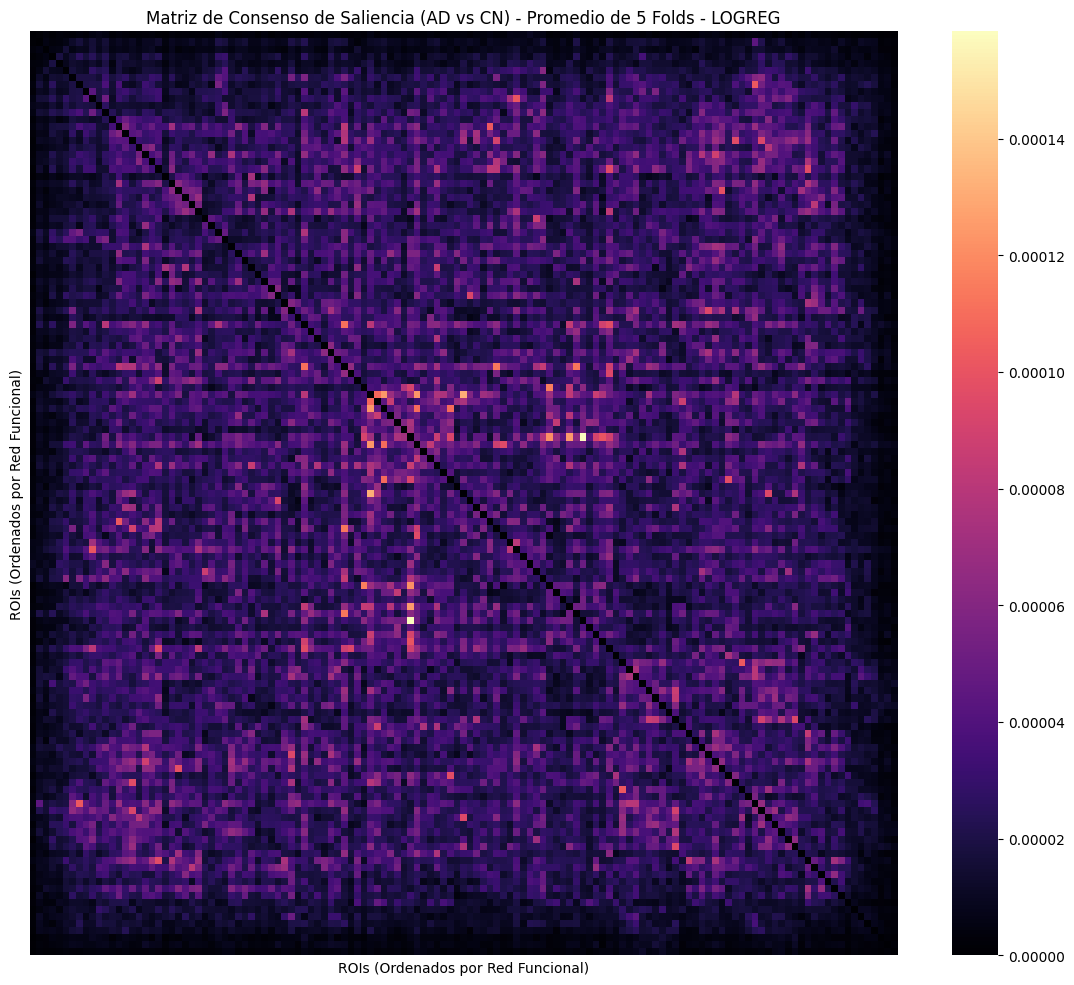

In [51]:
# consensus_matrix.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RUN_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25")
CLF = "logreg"

# 1. Cargar las matrices de saliencia (diferencia absoluta) de todos los folds
matrices = []
for f in range(1, 6):
    p = RUN_DIR / f"fold_{f}" / f"interpretability_{CLF}" / f"saliency_map_diff_abs_integrated_gradients_top50.npy"
    if p.exists():
        # El archivo guardado es (C, R, R) o (R, R) dependiendo de cómo se guardó.
        # Normalmente tu script guarda (C, R, R). Hacemos media sobre canales.
        sal = np.load(p)
        if sal.ndim == 3:
            sal = sal.mean(axis=0)
        matrices.append(sal)

if matrices:
    # 2. Calcular promedio
    consensus_matrix = np.mean(matrices, axis=0)
    
    # 3. Cargar nombres de ROIs para ejes (usamos el archivo generado en el run)
    roi_info = pd.read_csv(RUN_DIR / "roi_info_from_tensor.csv")
    roi_names = roi_info['roi_name_in_tensor'].values
    
    # 4. Plotear
    plt.figure(figsize=(14, 12))
    sns.heatmap(consensus_matrix, cmap="magma", xticklabels=False, yticklabels=False)
    plt.title(f"Matriz de Consenso de Saliencia (AD vs CN) - Promedio de 5 Folds - {CLF.upper()}")
    plt.xlabel("ROIs (Ordenados por Red Funcional)")
    plt.ylabel("ROIs (Ordenados por Red Funcional)")
    
    # Guardar
    out_path = RUN_DIR / "consensus_saliency_matrix.png"
    plt.savefig(out_path, dpi=300)
    print(f"Matriz de consenso guardada en: {out_path}")
    plt.show()
else:
    print("No se encontraron archivos de saliencia.")

In [52]:
# Celda 1 — Helpers globales para análisis SHAP/IG (SVM, beta66_manual)

from pathlib import Path
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.collections


# Ruta del proyecto / experimento (coherente con la primera parte del notebook)
PROJECT_ROOT = Path("/home/diego/proyectos/betavae-xai-ad/").resolve()
RUN_DIR = PROJECT_ROOT / "results" / "vae_clf_ad_3channels_beta25"
CLF = "logreg"
FOLDS = [1, 2, 3, 4, 5]

print("RUN_DIR:", RUN_DIR)

def prettify_feature(name: str) -> str:
    """Nombre amigable para tablas/plots (Age, Sex, latent_k)."""
    if re.search(r'(?:^|__)Age\b', name):
        return "Age"
    if re.search(r'(?:^|__)Sex\b', name):
        return "Sex"
    m = re.search(r'latent_(\d+)', name)
    if m:
        return f"latent {m.group(1)}"
    return name

def load_shap_pack(run_dir: Path, fold: int, clf: str, tag: str):
    """
    Carga shap_pack_<clf>_<tag>.joblib del fold dado.
    tag ∈ {'frozen','unfrozen'} en este notebook.
    """
    p = run_dir / f"fold_{fold}" / "interpretability_shap" / f"shap_pack_{clf}_{tag}.joblib"
    if not p.exists():
        raise FileNotFoundError(f"No existe: {p}")
    return joblib.load(p)

def ajustar_opacidad_violin(alpha: float = 0.35, subir_puntos: bool = True, ax=None):
    """
    Baja la opacidad de violines en shap.summary_plot y resalta el beeswarm.
    """
    ax = ax or plt.gca()
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
    for p in ax.patches:
        try:
            p.set_alpha(alpha)
        except Exception:
            pass
    if subir_puntos:
        for sc in ax.findobj(mpl.collections.PathCollection):
            sc.set_zorder(3)
            sc.set_edgecolor("white")
            sc.set_linewidth(0.4)

def save_multi(base_path: Path, dpi: int = 300):
    """
    Guarda la figura actual en PNG / SVG / PDF usando base_path sin extensión.
    """
    base_path = Path(base_path)
    for ext in (".png", ".svg", ".pdf"):
        out = base_path.with_suffix(ext)
        plt.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Guardado:", base_path.with_suffix(".png"), "(+ svg/pdf)")


RUN_DIR: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25


In [53]:
# Celda 2 — Importancia de latentes (FROZEN) por fold y consenso global

rows_per_fold = []
all_rows = []

for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="frozen")
    shap_vals = np.asarray(pack["shap_values"], float)   # (N,F)
    featnames = list(map(str, pack["feature_names"]))

    latent_mask = np.array([re.search(r'(?:^|__)latent_\d+\b', n) is not None
                            for n in featnames])
    if not latent_mask.any():
        raise RuntimeError(f"Fold {f}: no se detectaron columnas latentes en feature_names.")

    shap_lat = shap_vals[:, latent_mask]
    names_lat = np.array(featnames)[latent_mask]
    mean_abs = np.abs(shap_lat).mean(axis=0)

    df_fold = (pd.DataFrame({
                    "feature": names_lat,
                    "pretty_feature": [prettify_feature(n) for n in names_lat],
                    "mean_abs_shap": mean_abs,
                    "fold": f
               })
               .sort_values("mean_abs_shap", ascending=False)
               .reset_index(drop=True))

    rows_per_fold.append(df_fold)

    out_fold = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"fold{f}_latent_importance_FROZEN.csv"
    df_fold.to_csv(out_fold, index=False)
    print(f"Fold {f}: guardado ranking de latentes en {out_fold.name}")

    all_rows.append(df_fold)

df_all = pd.concat(all_rows, ignore_index=True)

df_global = (df_all
             .groupby(["feature", "pretty_feature"], as_index=False)
             .agg(mean_abs_shap_across_folds=("mean_abs_shap", "mean"),
                  std_abs_shap_across_folds=("mean_abs_shap", "std"),
                  n_folds=("fold", "nunique"))
             .sort_values("mean_abs_shap_across_folds", ascending=False))

out_global = RUN_DIR / "latent_importance_across_folds_FROZEN.csv"
df_global.to_csv(out_global, index=False)
print("\n✅ Guardado consenso de latentes (FROZEN):", out_global)
display(df_global.head(20))


Fold 1: guardado ranking de latentes en fold1_latent_importance_FROZEN.csv
Fold 2: guardado ranking de latentes en fold2_latent_importance_FROZEN.csv
Fold 3: guardado ranking de latentes en fold3_latent_importance_FROZEN.csv
Fold 4: guardado ranking de latentes en fold4_latent_importance_FROZEN.csv
Fold 5: guardado ranking de latentes en fold5_latent_importance_FROZEN.csv

✅ Guardado consenso de latentes (FROZEN): /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/latent_importance_across_folds_FROZEN.csv


,feature,pretty_feature,mean_abs_shap_across_folds,std_abs_shap_across_folds,n_folds
160,latent_242,latent 242,0.040893,0.032161,5
143,latent_227,latent 227,0.037058,0.028607,5
110,latent_198,latent 198,0.035583,0.016266,5
72,latent_163,latent 163,0.034202,0.033774,5
84,latent_174,latent 174,0.033020,0.014115,5
137,latent_221,latent 221,0.031844,0.024751,5
242,latent_87,latent 87,0.031796,0.023736,5
27,latent_122,latent 122,0.031732,0.016459,5
173,latent_254,latent 254,0.031667,0.034331,5
40,latent_134,latent 134,0.031277,0.018653,5


Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_1/interpretability_shap/fold1_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


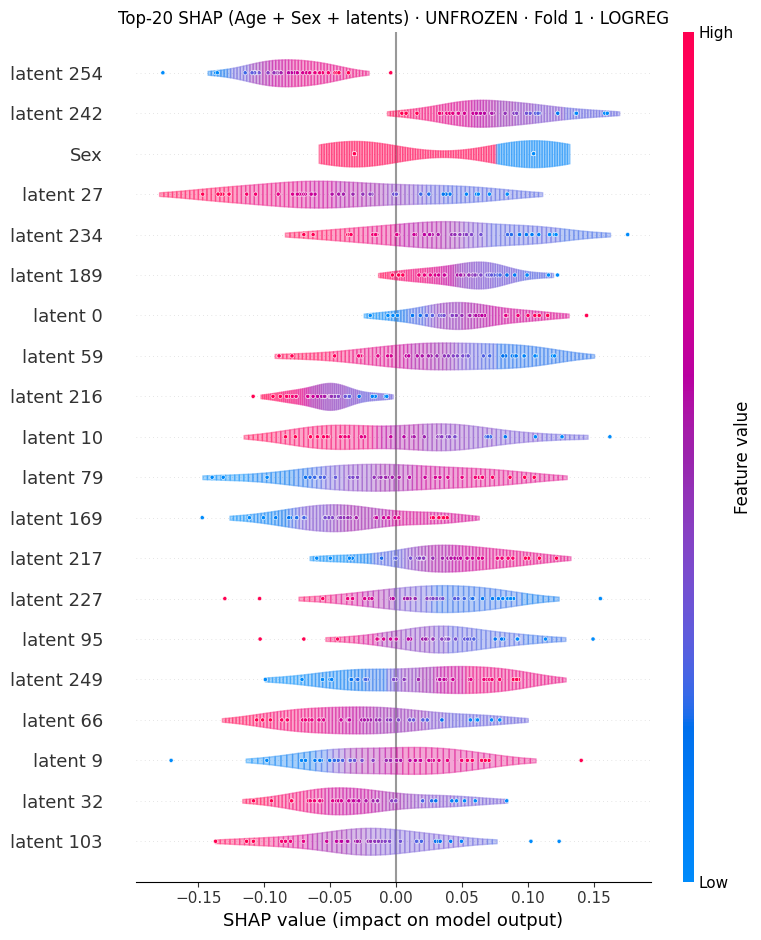

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_2/interpretability_shap/fold2_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


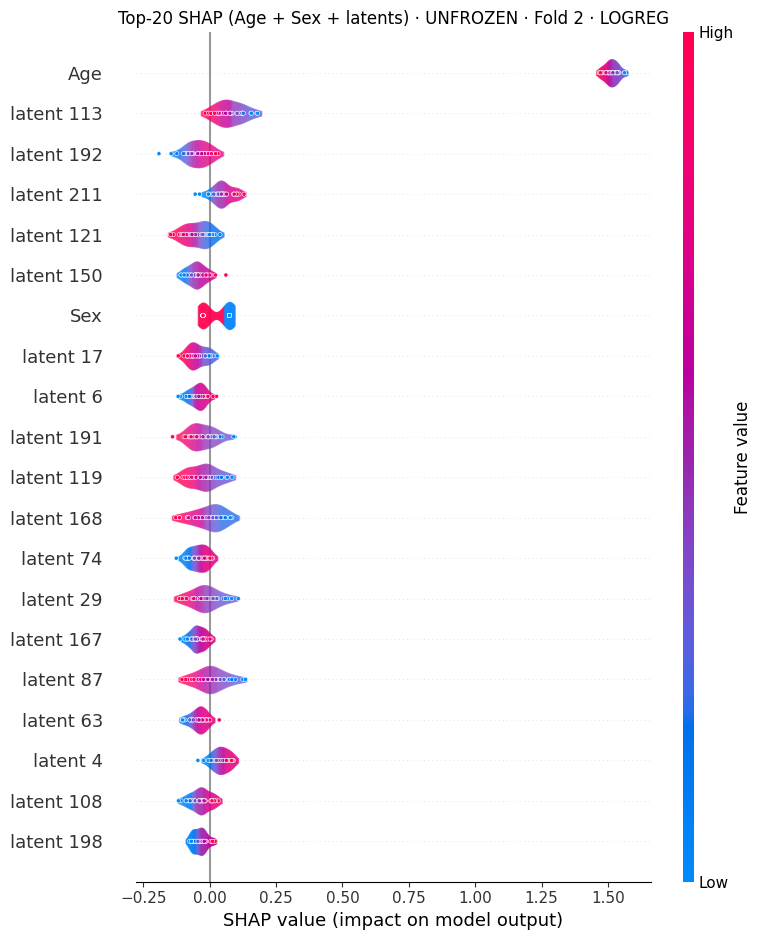

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_3/interpretability_shap/fold3_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


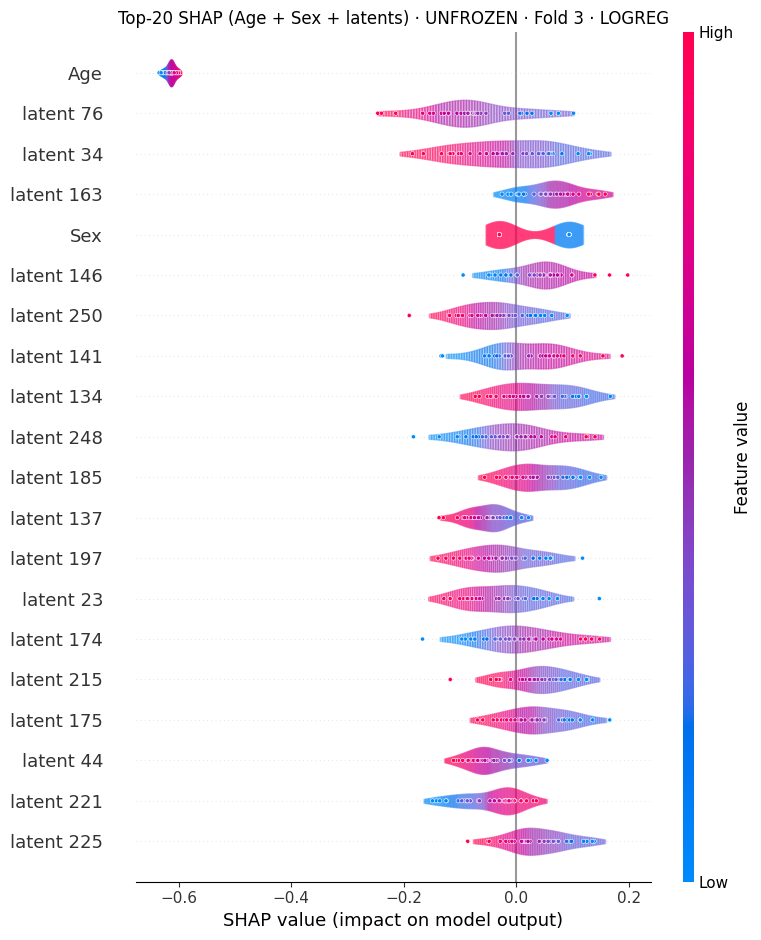

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_4/interpretability_shap/fold4_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


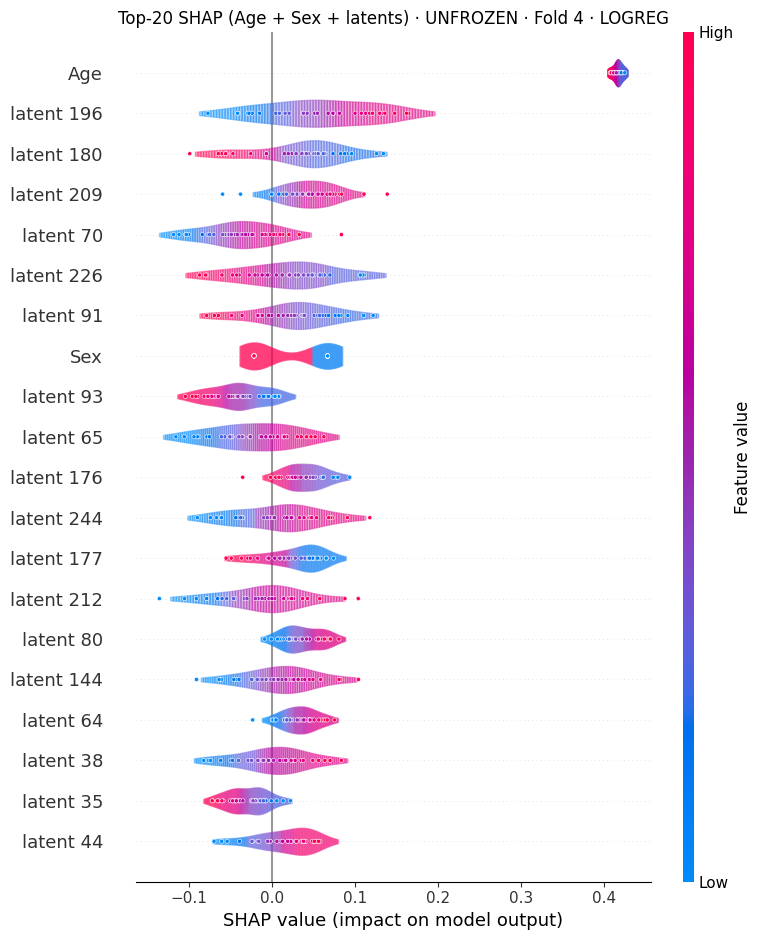

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_5/interpretability_shap/fold5_shap_top20_UNFROZEN_violin.png (+ svg/pdf)


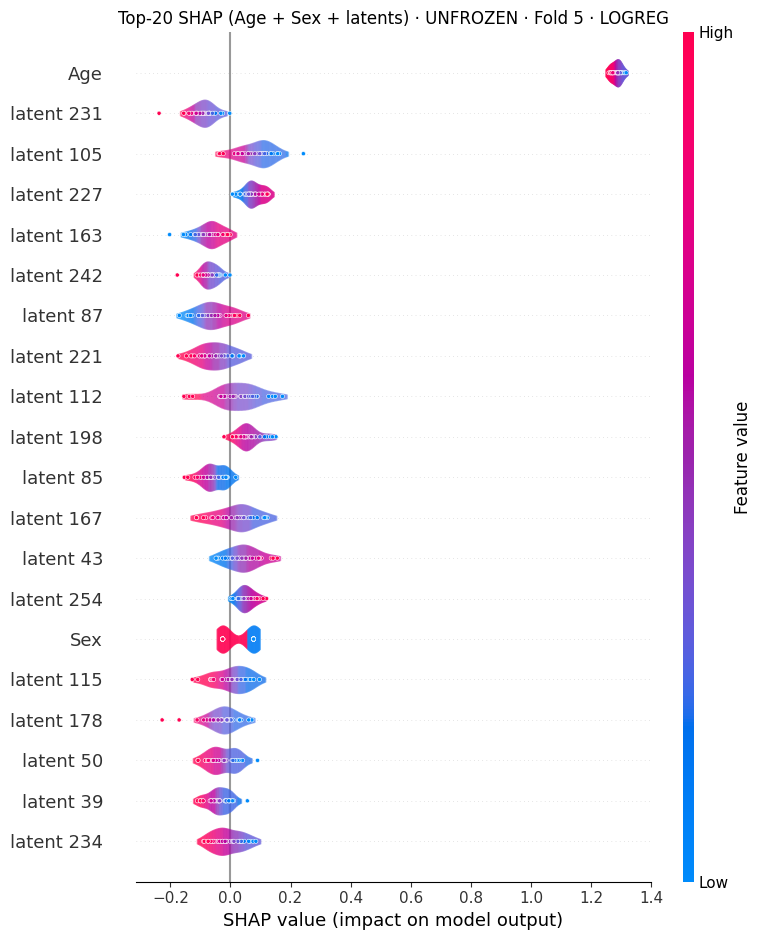

In [54]:
# Celda 3 — SHAP UNFROZEN: Top-20 features (Age, Sex, latentes) por fold

TOPK = 20

for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="unfrozen")
    shap_vals = np.asarray(pack["shap_values"], float)
    Xtest = pack["X_test"]
    featnames = list(map(str, pack["feature_names"]))

    mean_abs = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:TOPK]

    S_top = shap_vals[:, order]
    X_top = Xtest.iloc[:, order]
    pretty = [prettify_feature(featnames[i]) for i in order]

    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=pretty,
        max_display=TOPK,
        plot_type="violin",
        show=False
    )
    ajustar_opacidad_violin(alpha=0.35)

    plt.title(f"Top-{TOPK} SHAP (Age + Sex + latents) · UNFROZEN · Fold {f} · {CLF.upper()}")
    plt.tight_layout()

    out_base = RUN_DIR / f"fold_{f}" / "interpretability_shap" / f"fold{f}_shap_top{TOPK}_UNFROZEN_violin"
    save_multi(out_base)
    plt.show()
    plt.close()


In [64]:
# =================== CELDA 0 — CONFIG GLOBAL & HELPERS ===================
import os, sys, random, warnings, pathlib, logging
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

################################################################################
# 1. Reproducibilidad total
################################################################################
def seed_everything(seed: int = 42):
    """
    Fija todas las semillas pseudoaleatorias que razonablemente controlamos:
    - Python `random`
    - Hash aleatorio de Python
    - NumPy
    - (opcional) PyTorch si está disponible
    """
    import importlib

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if importlib.util.find_spec("torch") is not None:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)
        if torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

################################################################################
# 2. Estilo "Nature-ready" para todas las figuras
################################################################################
def set_nature_style():
    """
    Ajusta parámetros globales de Matplotlib/Seaborn para figuras tipo Nature:
    - texto editable en Illustrator (fonttype=42)
    - tamaños de fuente consistentes
    - ejes sin spines top/right
    - ticks hacia afuera
    """
    sns.set_theme(style="white", context="paper")
    mpl.rcParams.update({
        # texto editable en Illustrator / Affinity
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "svg.fonttype": "none",

        # tipografía
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],

        # tamaños (en pt aprox)
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # estética de ejes
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",

        # salida
        "figure.dpi": 300,
        "savefig.pad_inches": 0.02,
    })

set_nature_style()

################################################################################
# 3. Helper para guardar figuras en alta resolución listas para el paper
################################################################################
def savefig_nature(fig: mpl.figure.Figure,
                   path_no_ext,
                   dpi_png: int = 600,
                   transparent_png: bool = False,
                   extra_meta: dict | None = None):
    """
    Guarda dos versiones de la figura:
      - PDF (vectorial, texto editable)
      - PNG (alta resolución)
    """
    p = pathlib.Path(path_no_ext)
    p.parent.mkdir(parents=True, exist_ok=True)

    meta_pdf = {
        "Creator": "Matplotlib",
        "Title": p.name,
        "CreationDate": datetime.now(),
    }
    if extra_meta:
        meta_pdf.update(extra_meta)

    fig.savefig(p.with_suffix(".pdf"),
                metadata=meta_pdf,
                bbox_inches="tight")

    fig.savefig(p.with_suffix(".png"),
                dpi=dpi_png,
                transparent=transparent_png,
                metadata={"Creator": "Matplotlib"},
                bbox_inches="tight")

print("✔️  Celda 0 cargada: estilo Nature + savefig_nature disponible.\n")
logging.getLogger('fontTools').setLevel(logging.WARNING)
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
os.environ.setdefault("TQDM_DISABLE", "1")


✔️  Celda 0 cargada: estilo Nature + savefig_nature disponible.



'1'

Generando gráfico de Age (UNFROZEN) para fold 3...
Gráfico guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_3/interpretability_shap/Sup_S6_A_shap_Age_fold3_LOGREG.[png/pdf/svg]


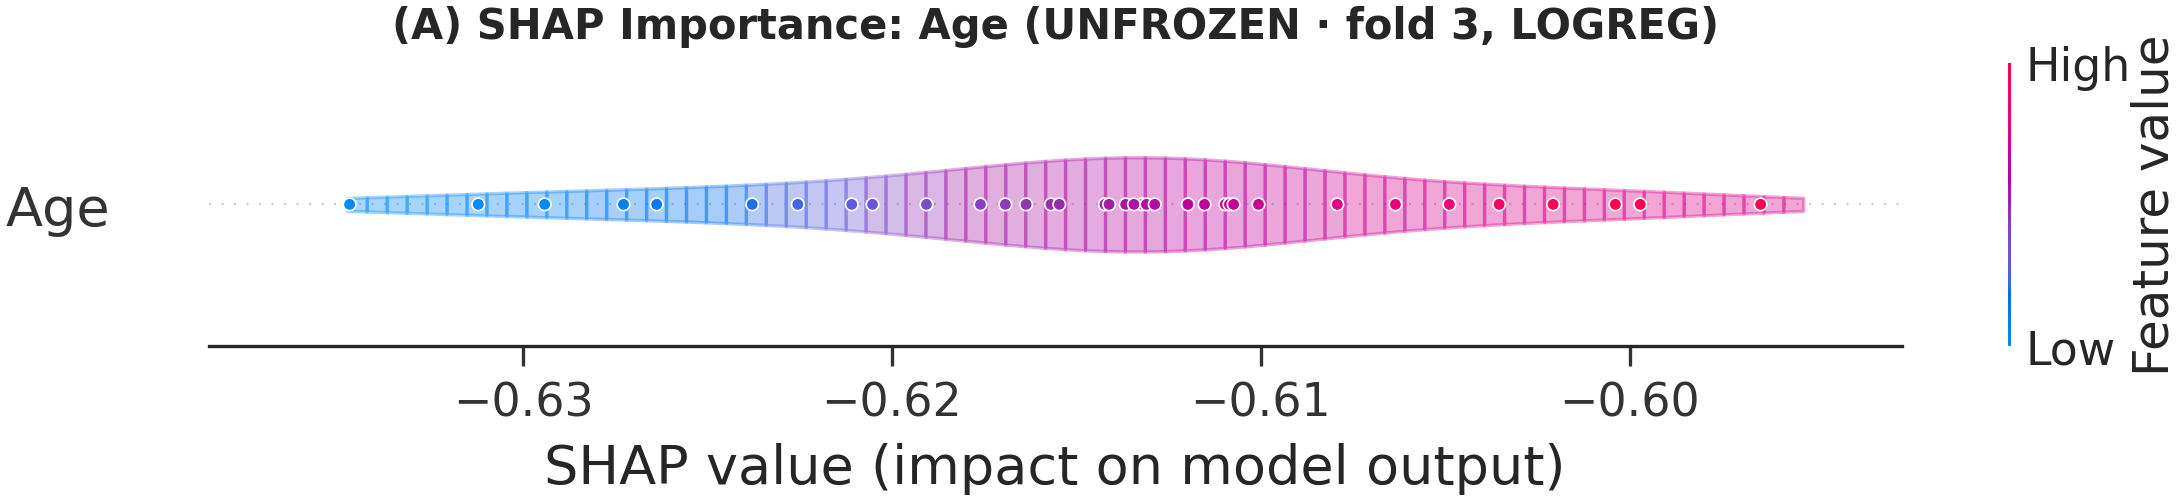

In [69]:
# =================== CELDA 4 — SHAP UNFROZEN: Age solo (Fold 3, escala limpia) ===================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import re

FOLD_AGE = 3
EPS = 1e-6  # para jitter mínimo

def plot_shap_single_feature(shap_vals_1d, x_1d, featname: str, title: str, out_base: Path):
    """
    summary_plot para una sola feature con:
      - jitter si X es casi constante
      - re-escala del eje X SOLO al rango real de los SHAP de esa feature
      - guardado con savefig_nature
    """
    # 1D -> columna
    s = np.asarray(shap_vals_1d, float).reshape(-1, 1)
    x = np.asarray(x_1d, float).reshape(-1, 1)

    # Jitter si Age casi no varía numéricamente
    if np.nanstd(x) < EPS:
        rng = np.random.default_rng(42)
        x = x + rng.normal(0.0, EPS, size=x.shape)

    df_x = pd.DataFrame({featname: x.ravel()})

    plt.figure(figsize=(7.0, 3.5))
    shap.summary_plot(
        s,
        df_x,
        feature_names=[featname],
        plot_type="violin",
        show=False,
        max_display=1,
        sort=False
    )

    ax = plt.gca()

    # --- Ajuste fino del eje X al rango real de SHAP(Age) ---
    s_flat = s[np.isfinite(s)]
    if s_flat.size:
        lo = float(s_flat.min())
        hi = float(s_flat.max())

        if np.isclose(hi, lo):
            # Si todos los SHAP son casi iguales, poné un rango simétrico chico
            delta = max(abs(lo), 1e-3)
            lo = lo - delta
            hi = hi + delta
        else:
            # Margen del 10%
            pad = 0.10 * (hi - lo)
            lo -= pad
            hi += pad
        ax.set_xlim(lo, hi)

    # Estética: violines transparentes y puntos por encima
    ajustar_opacidad_violin(alpha=0.35, subir_puntos=True, ax=ax)

    ax.set_title(title, fontsize=10, weight="bold")
    plt.tight_layout()

    # Guardar en PNG+PDF "Nature-ready"
    savefig_nature(plt.gcf(), out_base)
    # Guardado extra en SVG
    plt.gcf().savefig(out_base.with_suffix(".svg"),
                     format="svg", bbox_inches="tight")
    print(f"Gráfico guardado en: {out_base}.[png/pdf/svg]")
    plt.show()
    plt.close()


print(f"Generando gráfico de Age (UNFROZEN) para fold {FOLD_AGE}...")

# --- Cargar pack UNFROZEN del fold 3 ---
pack = load_shap_pack(RUN_DIR, FOLD_AGE, CLF, tag="unfrozen")
shap_vals = np.asarray(pack["shap_values"], float)
Xtest = pack["X_test"]
featnames = list(map(str, pack["feature_names"]))

# Buscar índice de Age entre las features
age_idx = [i for i, n in enumerate(featnames)
           if re.search(r'(?:^|__)Age\b', n)]
if not age_idx:
    print(f"⚠️ 'Age' no encontrado en feature_names del fold {FOLD_AGE}.")
else:
    i = age_idx[0]
    s_age = shap_vals[:, i]
    x_age = np.asarray(Xtest.iloc[:, i], float)

    out_dir = RUN_DIR / f"fold_{FOLD_AGE}" / "interpretability_shap"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_base = out_dir / f"Sup_S6_A_shap_Age_fold{FOLD_AGE}_{CLF.upper()}"

    plot_shap_single_feature(
        s_age,
        x_age,
        featname="Age",
        title=f"(A) SHAP Importance: Age (UNFROZEN · fold {FOLD_AGE}, {CLF.upper()})",
        out_base=out_base,
    )


Top latentes globales (por mean |SHAP|): ['latent_242', 'latent_227', 'latent_198']
Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_3/interpretability_shap/shap_latents_top3_UNFROZEN_fold3.png (+ svg/pdf)
Gráfico guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_3/interpretability_shap/shap_latents_top3_UNFROZEN_fold3.[png/pdf/svg]


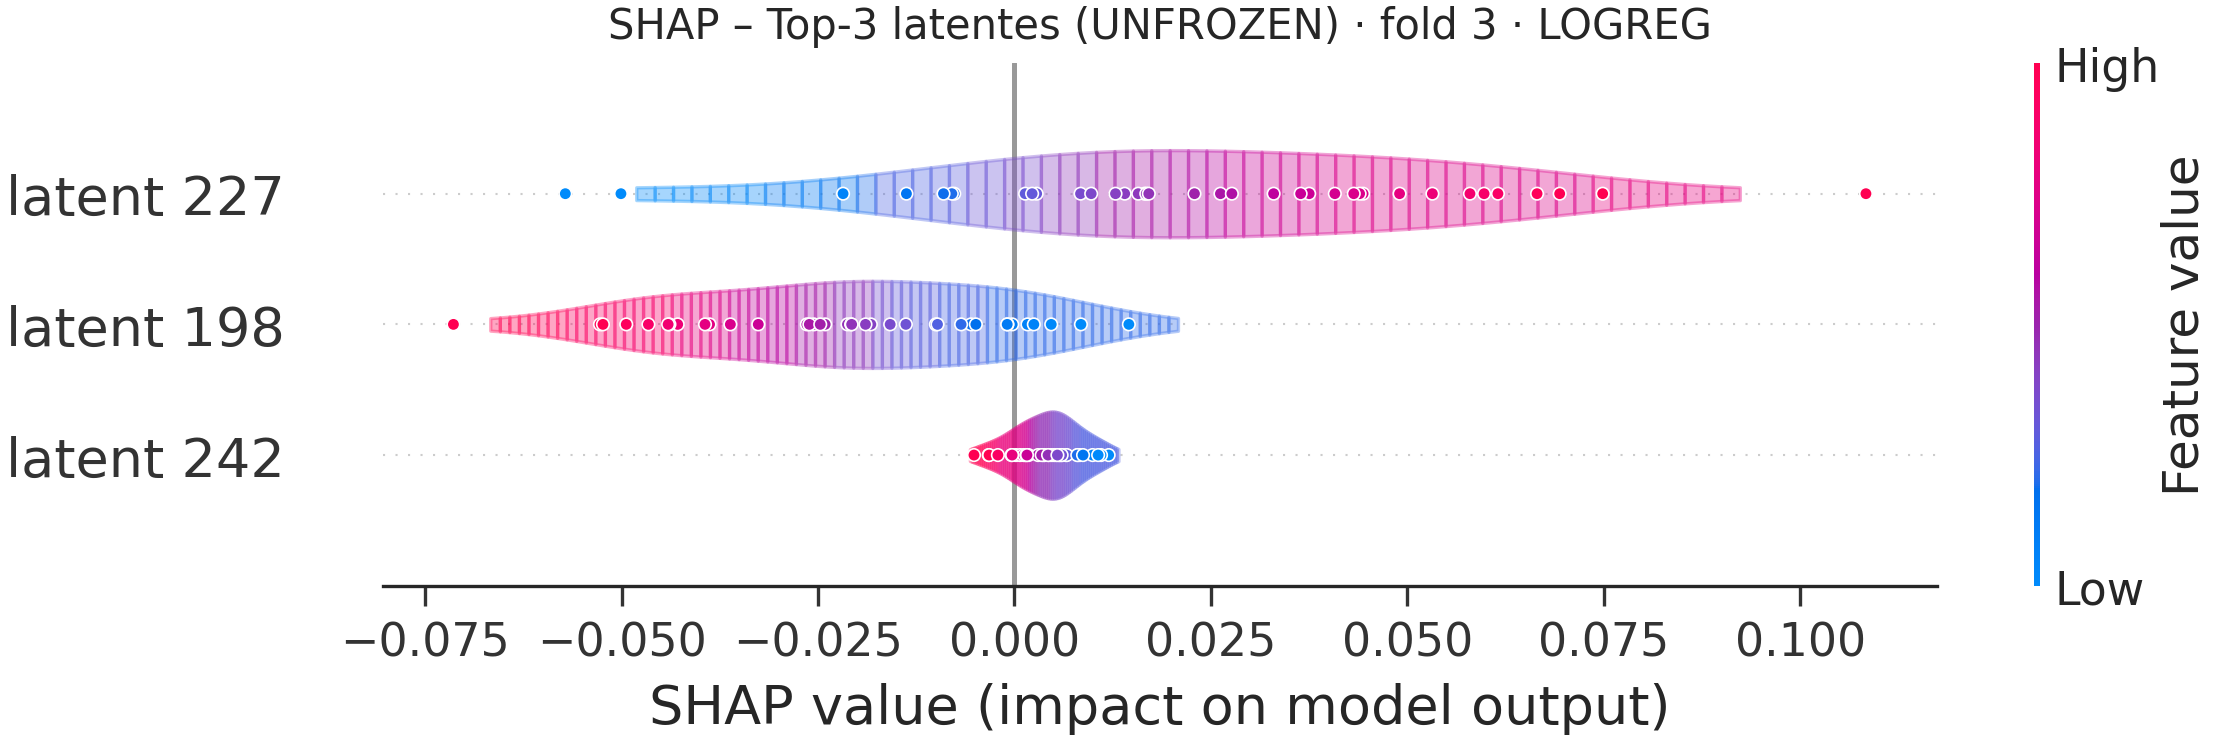

In [66]:
# Celda 5 — SHAP UNFROZEN: Top-3 latentes del ranking global, plot en fold 3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

FOLD_LAT = 3
N_LATENTS = 3

# 1) Construir ranking global (Age + Sex + latentes) en modo UNFROZEN
rows = []

for f in FOLDS:
    pack = load_shap_pack(RUN_DIR, f, CLF, tag="unfrozen")
    shap_vals = np.asarray(pack["shap_values"], float)
    featnames = list(map(str, pack["feature_names"]))

    mean_abs = np.abs(shap_vals).mean(axis=0)

    df_fold = pd.DataFrame({
        "feature": featnames,
        "pretty_name": [prettify_feature(n) for n in featnames],
        "mean_abs_shap": mean_abs,
        "fold": f
    })
    rows.append(df_fold)

df_all = pd.concat(rows, ignore_index=True)

df_summary = (
    df_all
    .groupby(["feature", "pretty_name"], as_index=False)
    .agg(mean_shap=("mean_abs_shap", "mean"),
         std_shap=("mean_abs_shap", "std"))
)

# 2) Quedarse sólo con latentes y tomar las Top-3 por mean_shap
mask_latent = df_summary["pretty_name"].str.startswith("latent ")
df_latents = df_summary[mask_latent].sort_values("mean_shap", ascending=False)

top_latents = df_latents.head(N_LATENTS)["feature"].tolist()
print("Top latentes globales (por mean |SHAP|):", top_latents)

# 3) Hacer summary_plot de esas latentes en el fold 3 (UNFROZEN)
pack3 = load_shap_pack(RUN_DIR, FOLD_LAT, CLF, tag="unfrozen")
shap_vals3 = np.asarray(pack3["shap_values"], float)
Xtest3 = pack3["X_test"]
featnames3 = list(map(str, pack3["feature_names"]))

# Indices de esas latentes en el diseño del fold 3
indices = []
for feat in top_latents:
    if feat in featnames3:
        indices.append(featnames3.index(feat))
    else:
        print(f"Advertencia: {feat} no está en feature_names de fold {FOLD_LAT}")

if not indices:
    print("No se encontraron latentes top en el fold 3; revisar.")
else:
    S_sel = shap_vals3[:, indices]
    X_sel = Xtest3.iloc[:, indices]
    pretty_sel = [prettify_feature(featnames3[i]) for i in indices]

    plt.figure(figsize=(7.5, 4.5))
    shap.summary_plot(
        S_sel,
        X_sel,
        feature_names=pretty_sel,
        plot_type="violin",
        max_display=len(indices),
        show=False
    )
    ajustar_opacidad_violin(alpha=0.35)
    plt.title(
        f"SHAP – Top-{len(indices)} latentes (UNFROZEN) · fold {FOLD_LAT} · {CLF.upper()}"
    )
    plt.tight_layout()

    out_dir = RUN_DIR / f"fold_{FOLD_LAT}" / "interpretability_shap"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_base = out_dir / f"shap_latents_top{len(indices)}_UNFROZEN_fold{FOLD_LAT}"
    save_multi(out_base)
    print(f"Gráfico guardado en: {out_base}.[png/pdf/svg]")
    plt.show()
    plt.close()


In [67]:
# Celda 5 — Consenso de edges salientes (IG, SVM, top-50 latentes por fold)

import itertools

TAG = "integrated_gradients_top50"
clf = CLF  # alias

edge_dfs = []
edge_sets_top = []
TOP_EDGES_PER_FOLD = 200  # para el Jaccard; ajustalo si querés

def edge_key_df(df: pd.DataFrame) -> pd.Series:
    """Clave de arista no dirigida a partir de nombres de AAL3."""
    a = df["src_AAL3_Name"].astype(str)
    b = df["dst_AAL3_Name"].astype(str)
    return pd.DataFrame({"a": a, "b": b}).apply(
        lambda r: tuple(sorted((r["a"], r["b"]))),
        axis=1
    )

for f in FOLDS:
    csv_path = RUN_DIR / f"fold_{f}" / f"interpretability_{clf}" / f"ranking_conexiones_ANOTADO_{TAG}.csv"
    if not csv_path.exists():
        print(f"Fold {f}: no encontré {csv_path.name}, se omite.")
        continue

    df = pd.read_csv(csv_path)
    df["edge_key"] = edge_key_df(df)
    df["fold"] = f
    edge_dfs.append(df)

    topK = df.head(TOP_EDGES_PER_FOLD)
    edge_sets_top.append(set(topK["edge_key"]))

if not edge_dfs:
    print("No se encontró ningún ranking_conexiones_ANOTADO_...; revisá rutas.")
else:
    # Jaccard promedio entre folds para los top-K
    jaccs = []
    for (i, s_i), (j, s_j) in itertools.combinations(enumerate(edge_sets_top), 2):
        inter = len(s_i & s_j)
        union = len(s_i | s_j)
        j = inter / union if union else 0.0
        jaccs.append(j)
    if jaccs:
        print(f"Mean Jaccard (top-{TOP_EDGES_PER_FOLD} edges por fold): {np.mean(jaccs):.3f}")

    # Consenso global: frecuencia y saliencia media
    df_all_edges = pd.concat(edge_dfs, ignore_index=True)

    gb = (df_all_edges
          .groupby("edge_key", as_index=False)
          .agg(freq=("fold", "nunique"),
               Saliency_Abs_mean=("Saliency_Abs", "mean"),
               Saliency_Signed_mean=("Saliency_Signed", "mean"),
               src_name=("src_AAL3_Name", "first"),
               dst_name=("dst_AAL3_Name", "first"),
               src_network=("src_Refined_Network", "first"),
               dst_network=("dst_Refined_Network", "first"))
          .sort_values(["freq", "Saliency_Abs_mean"], ascending=[False, False]))

    out_edges = RUN_DIR / f"consensus_edges_{clf}_{TAG}.csv"
    gb.to_csv(out_edges, index=False)
    print("✅ Guardado consenso de edges en:", out_edges)

    display(gb.head(25))


Mean Jaccard (top-200 edges por fold): 0.048
✅ Guardado consenso de edges en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/consensus_edges_logreg_integrated_gradients_top50.csv


,edge_key,freq,Saliency_Abs_mean,Saliency_Signed_mean,src_name,dst_name,src_network,dst_network
173,"(ACC_pre_R, Frontal_Med_Orb_R)",5,0.000158,-0.000140,Frontal_Med_Orb_R,ACC_pre_R,Limbic_B_OFC,DefaultMode_VentralMedial
4960,"(Frontal_Mid_2_L, OFCant_L)",5,0.000132,0.000102,OFCant_L,Frontal_Mid_2_L,Limbic_B_OFC,Control_A
4864,"(Frontal_Med_Orb_R, Frontal_Sup_Medial_L)",5,0.000125,-0.000092,Frontal_Med_Orb_R,Frontal_Sup_Medial_L,Limbic_B_OFC,DefaultMode_VentralMedial
6172,"(OFCant_L, OFCmed_L)",5,0.000124,0.000039,OFCant_L,OFCmed_L,Limbic_B_OFC,Limbic_B_OFC
6169,"(OFCant_L, OFCant_R)",5,0.000123,0.000027,OFCant_L,OFCant_R,Limbic_B_OFC,Limbic_B_OFC
44,"(ACC_pre_L, Frontal_Med_Orb_R)",5,0.000121,-0.000065,Frontal_Med_Orb_R,ACC_pre_L,Limbic_B_OFC,DefaultMode_VentralMedial
43,"(ACC_pre_L, Frontal_Med_Orb_L)",5,0.000116,-0.000009,Frontal_Med_Orb_L,ACC_pre_L,Limbic_B_OFC,DefaultMode_VentralMedial
5249,"(Frontal_Sup_2_R, Temporal_Inf_R)",5,0.000113,0.000006,Temporal_Inf_R,Frontal_Sup_2_R,Limbic_A_TempPole,Control_B
8190,"(Temporal_Inf_R, Temporal_Mid_L)",5,0.000113,-0.000055,Temporal_Inf_R,Temporal_Mid_L,Limbic_A_TempPole,DefaultMode_VentralMedial
8164,"(Temporal_Inf_L, Temporal_Inf_R)",5,0.000111,0.000031,Temporal_Inf_L,Temporal_Inf_R,Limbic_A_TempPole,Limbic_A_TempPole


In [68]:
# Celda 6 — Consenso de aporte por canal (IG, SVM, top-50 latentes)

rows = []
TAG = "integrated_gradients_top50"
clf = CLF

for f in FOLDS:
    csv_path = RUN_DIR / f"fold_{f}" / f"interpretability_{clf}" / f"channel_contributions_{TAG}.csv"
    if not csv_path.exists():
        print(f"Fold {f}: no encontré {csv_path.name}, se omite.")
        continue
    df = pd.read_csv(csv_path)
    df["fold"] = f
    rows.append(df)

if not rows:
    print("No se encontraron archivos channel_contributions_*.csv.")
else:
    df_all = pd.concat(rows, ignore_index=True)

    g = (df_all
         .groupby(["channel_index_used", "channel_name"], as_index=False)
         .agg(frac_mean=("l1_norm_fraction_abs", "mean"),
              frac_std=("l1_norm_fraction_abs", "std"),
              n_folds=("fold", "nunique"))
         .sort_values("frac_mean", ascending=False))

    out_chan = RUN_DIR / f"channels_consensus_{clf}_{TAG}.csv"
    g.to_csv(out_chan, index=False)
    print("✅ Guardado consenso de canales en:", out_chan)

    display(g)


✅ Guardado consenso de canales en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/channels_consensus_logreg_integrated_gradients_top50.csv


,channel_index_used,channel_name,frac_mean,frac_std,n_folds
2,2,Ch2,0.367571,0.020520,5
1,1,Ch1,0.348463,0.024845,5
0,0,Ch0,0.283966,0.013990,5
